---
# IMDB_SAMPLE Sentiment Classifier:
---

In [2]:
!pip install fastai2

In [0]:
from fastai2.text.all import *

In [4]:
path = untar_data(URLs.IMDB_SAMPLE)
Path.BASE_PATH = patch
path.ls()

(#1) [Path('/root/.fastai/data/imdb_sample/texts.csv')]

In [5]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False
1,positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is som...",False
2,negative,"Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt li...",False
3,positive,"Name just says it all. I watched this movie with my dad when it came out and having served in Korea he had great admiration for the man. The disappointing thing about this film is that it only concentrate on a short period of the man's life - interestingly enough the man's entire life would have made such an epic bio-pic that it is staggering to imagine the cost for production.<br /><br />Some posters elude to the flawed characteristics about the man, which are cheap shots. The theme of the movie ""Duty, Honor, Country"" are not just mere words blathered from the lips of a high-brassed offic...",False
4,negative,"This movie succeeds at being one of the most unique movies you've seen. However this comes from the fact that you can't make heads or tails of this mess. It almost seems as a series of challenges set up to determine whether or not you are willing to walk out of the movie and give up the money you just paid. If you don't want to feel slighted you'll sit through this horrible film and develop a real sense of pity for the actors involved, they've all seen better days, but then you realize they actually got paid quite a bit of money to do this and you'll lose pity for them just like you've alr...",False


In [6]:
dls_lm = DataBlock(
    blocks=TextBlock.from_df('text', is_lm=True),
    get_x=ColReader('text'), 
    splitter=RandomSplitter(0.1)
).dataloaders(df, bs=128, seq_len=80)

dls_lm.show_batch(max_n=3)

,text,text_
0,"xxbos i ordered this extremely rare and highly overrated movie on xxunk with very high expectations . i think i paid about 50 $ for this movie . xxmaj as an xxunk fan of horror , from cheesy 80s xxmaj american slashers to xxmaj european zombie films , i told myself this was going to be great ! i ca n't tell you how wrong i was . xxmaj first of all , i thought it was gon na be","i ordered this extremely rare and highly overrated movie on xxunk with very high expectations . i think i paid about 50 $ for this movie . xxmaj as an xxunk fan of horror , from cheesy 80s xxmaj american slashers to xxmaj european zombie films , i told myself this was going to be great ! i ca n't tell you how wrong i was . xxmaj first of all , i thought it was gon na be pretty"
1,( both chewing the scenery ) and a cape that turns people into vampires ! xxmaj there 's also a cute line about xxmaj christopher xxmaj lee playing xxmaj dracula . \n\n xxmaj this is a good horror anthology -- nothing terrifying but the first one and the ending of the third gave me a few xxunk little chills . xxmaj also the fourth one is actually very funny and xxmaj pitt makes a xxup very sexy vampire ! xxmaj,both chewing the scenery ) and a cape that turns people into vampires ! xxmaj there 's also a cute line about xxmaj christopher xxmaj lee playing xxmaj dracula . \n\n xxmaj this is a good horror anthology -- nothing terrifying but the first one and the ending of the third gave me a few xxunk little chills . xxmaj also the fourth one is actually very funny and xxmaj pitt makes a xxup very sexy vampire ! xxmaj also
2,"comes out on video , i know that i got a kick out of it , i mean lets all be honest here , sometimes its comforting to xxunk in the shortcomings of others . xxbos xxmaj how to xxmaj lose xxmaj friends & xxmaj alienate xxmaj people is in all honesty one of the best comedies xxmaj i 've seen this year along with xxmaj xxunk xxmaj express and xxmaj step xxmaj brothers . xxmaj its not one of","out on video , i know that i got a kick out of it , i mean lets all be honest here , sometimes its comforting to xxunk in the shortcomings of others . xxbos xxmaj how to xxmaj lose xxmaj friends & xxmaj alienate xxmaj people is in all honesty one of the best comedies xxmaj i 've seen this year along with xxmaj xxunk xxmaj express and xxmaj step xxmaj brothers . xxmaj its not one of those"


### Tokenizer

In [0]:
def print_rules(dls):
  "Prints out current rules of `Tokenizer`"
  print(f"{dls.tokenizer[0].__doc__} with the following rules\n")
  [print(f"{r.__name__, r.__doc__}") for r in dls.rules]

In [8]:
print_rules(dls_lm)

Spacy tokenizer for `lang` with the following rules

('fix_html', "Various messy things we've seen in documents")
('replace_rep', 'Replace repetitions at the character level: cccc -- TK_REP 4 c')
('replace_wrep', 'Replace word repetitions: word word word word -- TK_WREP 4 word')
('spec_add_spaces', 'Add spaces around / and #')
('rm_useless_spaces', 'Remove multiple spaces')
('replace_all_caps', 'Replace tokens in ALL CAPS by their lower version and add `TK_UP` before.')
('replace_maj', 'Replace tokens in ALL CAPS by their lower version and add `TK_UP` before.')
('lowercase', 'Converts `t` to lowercase')


In [9]:
len(dls_lm.vocab)

7080

In [10]:
dls_lm.tokenizer

(#2) [<fastai2.text.core.SpacyTokenizer object at 0x7f894f42b8d0>,Tokenizer: (str,object) -> encodes
(Path,object) -> encodes (object,object) -> decodes]

In [11]:
txts = L(i for i in df['text'])
txts[0]

"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!"

In [12]:
tok = Tokenizer.from_df(df)
tok.setup(txts)
toks = txts.map(tok)
toks[0]

(#108) ['xxbos','xxmaj','un','-','bleeping','-','believable','!','xxmaj','meg'...]

### Numericalization

In [13]:
num = Numericalize()
num.setup(toks)
nums = toks.map(num)
nums[0][:10]

tensor([   2,    8, 4499,   24,    0,   24,  951,   54,    8, 4500])

In [14]:
nums_dec = num.decode(nums[0][:10])
nums_dec

(#10) ['xxbos','xxmaj','un','-','xxunk','-','believable','!','xxmaj','meg']

In [15]:
tok.decode(nums_dec)

'xxbos xxmaj un - xxunk - believable ! xxmaj meg'

In [16]:
[(dls_lm.o2i[i], i)for i in dls_lm.vocab[:10]]

[(0, 'xxunk'),
 (1, 'xxpad'),
 (2, 'xxbos'),
 (3, 'xxeos'),
 (4, 'xxfld'),
 (5, 'xxrep'),
 (6, 'xxwrep'),
 (7, 'xxup'),
 (8, 'xxmaj'),
 (9, 'the')]

In [17]:
dls_lm.numericalize

Numericalize: (object,object) -> encodes (object,object) -> decodes

### Fine-tuning LM:

In [18]:
# fine-tuning wikitext LM to IMDB dataset
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.02754228748381138)

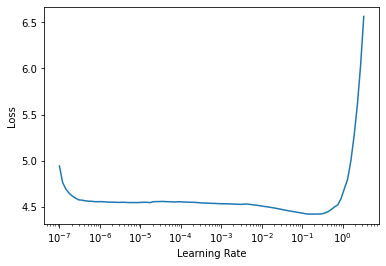

In [19]:
learn.lr_find()

In [20]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.366515,4.147547,0.271983,63.278603,00:09


In [0]:
learn.freeze_to(-2)
# learn.lr_find()

In [0]:
lr = 1e-3

In [23]:
learn.fit_one_cycle(1, lr)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.132941,4.082130,0.275917,59.271610,00:09


In [0]:
# lr = slice(lr/(2.6**4), lr)

In [0]:
learn.freeze_to(-3)
# learn.lr_find()

In [26]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.048110,4.017125,0.280690,55.541176,00:10


In [0]:
learn.unfreeze()
# learn.lr_find()

In [28]:
lr = 1e-3
learn.fit_one_cycle(10, slice(lr/(2.6**4), lr))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.992895,4.010519,0.280703,55.175476,00:10
1,3.977167,3.987679,0.281207,53.929546,00:10
2,3.949693,3.951201,0.284296,51.997787,00:10
3,3.910280,3.925259,0.285132,50.666180,00:11
4,3.868229,3.905923,0.285951,49.695911,00:11
5,3.828448,3.899000,0.286472,49.353081,00:11
6,3.796680,3.894414,0.287625,49.127266,00:11
7,3.772398,3.891500,0.287831,48.984283,00:11
8,3.755093,3.890332,0.288252,48.927128,00:11
9,3.744763,3.889956,0.288151,48.908745,00:11


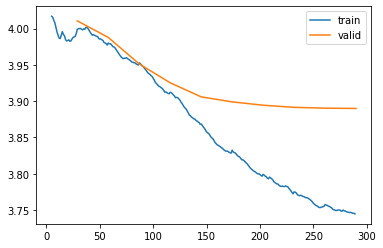

In [29]:
learn.recorder.plot_loss()

In [0]:
learn.save_encoder('fine_tuned_enc')

In [0]:
blocks = (TextBlock.from_df('text', seq_len=dls_lm.seq_len, vocab=dls_lm.vocab), CategoryBlock())
imdb_clas = DataBlock(blocks=blocks,
                      get_x=ColReader('text'),
                      get_y=ColReader('label'),
                      splitter=ColSplitter())

In [0]:
dls = imdb_clas.dataloaders(df, bs=64)

In [0]:
dls.show_batch(max_n=3)

,text,category
0,"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n\n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj victor xxmaj vargas became i was always aware that something did n't quite feel right . xxmaj victor xxmaj vargas suffers from a certain xxunk on the director 's part . xxmaj apparently , the director thought that the ethnic backdrop of a xxmaj latino family on the lower east side , and an xxunk storyline would make the film critic proof . xxmaj he was right , but it did n't fool me . xxmaj raising xxmaj victor xxmaj vargas is",negative
1,"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the xxunk and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with the xxunk possible scenarios to get the two protagonists together in the end . xxmaj in fact , all its charm is xxunk , contained within the characters and the setting and the plot … which is highly believable to xxunk . xxmaj it 's easy to think that such a love story , as beautiful as any other ever told , * could * happen to you … a feeling you do n't often get from other romantic comedies",positive
2,"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n\n xxmaj it 's usually satisfying to watch a film director change his style / subject , but xxmaj soderbergh 's most recent stinker , xxmaj the xxmaj girlfriend xxmaj xxunk ) , was also missing a story , so narrative ( and editing ? ) seem to suddenly be xxmaj soderbergh 's main challenge . xxmaj strange , after xxunk years in the business . xxmaj he was probably never much good at narrative , just xxunk it well inside "" edgy "" projects . \n\n xxmaj none of this excuses him this present , almost diabolical",negative


In [0]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()
learn.load_encoder('fine_tuned_enc')

In [0]:
learn.model

SequentialRNN(
  (0): SentenceEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(7080, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(7080, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): LinBnDrop(
        (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Dropout(p=0.2, inplace=False)
        (2): Linear(in_features=1200, out_features=50, bias=False)
        (3): ReLU(inplace=True)


SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.10000000149011612)

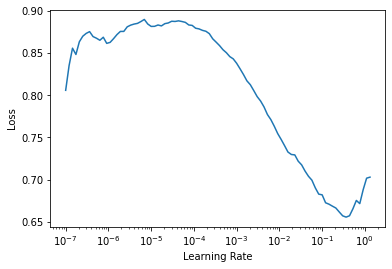

In [0]:
learn.lr_find()

In [0]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.688072,0.631326,0.730000,00:03


In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.687687,0.651127,0.750000,00:04


In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.488958,0.565560,0.750000,00:05


In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.431754,0.511765,0.790000,00:07
1,0.419593,0.529540,0.785000,00:07


SuggestedLRs(lr_min=0.0009120108559727668, lr_steep=9.12010818865383e-07)

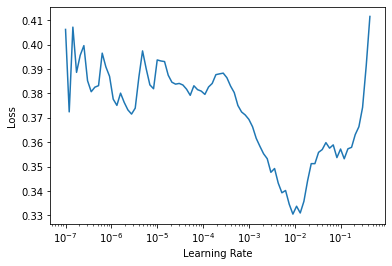

In [0]:
learn.lr_find()

In [0]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.356499,0.567929,0.785000,00:07
1,0.303489,0.608293,0.800000,00:07
2,0.259344,0.652440,0.810000,00:07
3,0.230272,0.668236,0.805000,00:07
4,0.200847,0.645074,0.805000,00:06


SuggestedLRs(lr_min=4.786300996784121e-05, lr_steep=1.5848931980144698e-06)

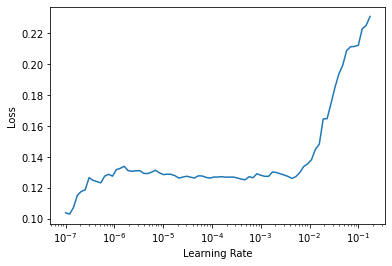

In [0]:
learn.lr_find()

---